In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from math import log

### Перед непосредственной имплементацией модели отмечу несколько важных моментов

Основным преимущетвом статистической модели перед ее аналогами (экономической и фундаментальной) является универсальность модели. Однажды выбрав тип построения модели (FA, PCA и др.) дальнейшее построение модели выполняется по алгоритму, то есть аналитик компании, который использует модель не сможет по своей неопытности совершить грубую ошибку. В аналогах набор факторов может варьироваться от одного актива к другому (от индустрии к индустрии и тп), поэтому старший аналитик не сможет с должной степенью уверенности положить процесс построения модели на младшего сотрудника. 

Еще одним преимуществом является то, что у модели много параметров по которым можно производить фит модели, что с точки зрения ML может позволять повышать точность. (Например, при анализе главных компонент появляется параметр кол-ва факторов, который, что не очевидно, лучший результат дает не при максимально возможном количестве компонент).

Главным недостатком модели перед аналогами является невозможность интерпретации факторов, так как в большинстве моделей это синтетические портфели из разных активов и тп.

В статье "The Three Types of Factor Models: A Comparison of Their Explanatory Power, Gregory Connor, 1995" проводилось сравнение объясняющей силы экон, фунд. и стат. факторных моделей. Вывод статьи, основаннный на исторических данных, был такой - фундаментальные модели превосходят статистические, а статистичаеские превосходят экономические.

Я выбрал данную модель, потому что уже имел опыт работы с экономическими и фундаментальными моделями. Будет интересно посмотреть, какие результаты продемонстрирует модель. После построения модели применю набор построенных факторов для построения динамической портфельной отпимизации по Марковицу.

## Перейдем к неосредственной имплементации

### Нужно получить матрицу ретернов, где по столбцам будут стоять интрументы, по строкам дата

In [3]:
snp500 = pd.read_csv('snp500.csv', delimiter = ',')
#snp500 = snp500.loc[snp500['date'] > '2019-01-01']
snp500.head()

,symbol,date,open,high,low,close,vwap,market_cap
0,AEP UN Equity,2005-01-03,34.21,34.29,33.95,34.02,34.0965,13461.8774
1,AEP UN Equity,2005-01-04,34.05,34.34,33.87,33.89,34.1061,13410.4358
2,AEP UN Equity,2005-01-05,33.85,33.98,33.41,33.49,33.7044,13252.1539
3,AEP UN Equity,2005-01-06,33.60,33.61,33.25,33.50,33.4529,13256.1109
4,AEP UN Equity,2005-01-07,33.61,34.09,33.31,33.37,33.6251,13204.6693


### Проверим данные на наличие NA

In [4]:
snp500.isnull().values.any()

False

In [5]:
snp500 = snp500.pivot_table(index='date', columns='symbol', values='close', aggfunc='sum', fill_value=0)

In [6]:
snp500.head()

symbol,A UN Equity,AAL UW Equity,AAP UN Equity,AAPL UW Equity,ABBV UN Equity,ABC UN Equity,ABMD UW Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,...,XEL UW Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,XYL UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity,ZTS UN Equity
date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,16.0896,0.0,29.033,4.5243,0.0,14.1063,15.01,22.3303,26.37,30.845,...,0.0,29.33,50.09,27.820,44.7090,0.0,16.8331,79.38,67.39,0.0
2005-01-04,15.6652,0.0,28.840,4.5671,0.0,13.9947,14.98,22.1055,25.75,30.030,...,0.0,28.44,49.75,27.595,44.0504,0.0,16.6102,79.35,66.47,0.0
2005-01-05,15.6584,0.0,28.893,4.6071,0.0,13.9680,14.69,21.8519,25.65,29.865,...,0.0,27.54,49.49,27.270,43.1810,0.0,16.5706,78.73,66.23,0.0
2005-01-06,15.3148,0.0,28.867,4.6107,0.0,14.0869,14.52,22.3447,25.42,29.370,...,0.0,27.10,50.12,27.400,42.9966,0.0,16.7576,79.64,66.61,0.0
2005-01-07,15.3013,0.0,28.700,4.9464,0.0,14.0456,14.29,22.7275,26.61,29.390,...,0.0,27.33,49.79,27.190,42.7594,0.0,16.6641,79.50,64.99,0.0


In [7]:
snp500r = snp500.pct_change()

In [8]:
snp500r.head()

symbol,A UN Equity,AAL UW Equity,AAP UN Equity,AAPL UW Equity,ABBV UN Equity,ABC UN Equity,ABMD UW Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,...,XEL UW Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,XYL UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity,ZTS UN Equity
date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,-0.026377,NaN,-0.006648,0.009460,NaN,-0.007911,-0.001999,-0.010067,-0.023512,-0.026422,...,NaN,-0.030344,-0.006788,-0.008088,-0.014731,NaN,-0.013242,-0.000378,-0.013652,NaN
2005-01-05,-0.000434,NaN,0.001838,0.008758,NaN,-0.001908,-0.019359,-0.011472,-0.003883,-0.005495,...,NaN,-0.031646,-0.005226,-0.011777,-0.019736,NaN,-0.002384,-0.007813,-0.003611,NaN
2005-01-06,-0.021943,NaN,-0.000900,0.000781,NaN,0.008512,-0.011572,0.022552,-0.008967,-0.016575,...,NaN,-0.015977,0.012730,0.004767,-0.004270,NaN,0.011285,0.011558,0.005738,NaN
2005-01-07,-0.000882,NaN,-0.005785,0.072809,NaN,-0.002932,-0.015840,0.017132,0.046814,0.000681,...,NaN,0.008487,-0.006584,-0.007664,-0.005517,NaN,-0.005580,-0.001758,-0.024321,NaN


### Из-за того, что в котировках было много нулей, ретерны выдали NaN-ы

In [9]:
snp500r = snp500r.dropna(axis = 1, how = 'all')
snp500r.head()

symbol,A UN Equity,AAL UW Equity,AAP UN Equity,AAPL UW Equity,ABBV UN Equity,ABC UN Equity,ABMD UW Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,...,XEL UW Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,XYL UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity,ZTS UN Equity
date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,-0.026377,NaN,-0.006648,0.009460,NaN,-0.007911,-0.001999,-0.010067,-0.023512,-0.026422,...,NaN,-0.030344,-0.006788,-0.008088,-0.014731,NaN,-0.013242,-0.000378,-0.013652,NaN
2005-01-05,-0.000434,NaN,0.001838,0.008758,NaN,-0.001908,-0.019359,-0.011472,-0.003883,-0.005495,...,NaN,-0.031646,-0.005226,-0.011777,-0.019736,NaN,-0.002384,-0.007813,-0.003611,NaN
2005-01-06,-0.021943,NaN,-0.000900,0.000781,NaN,0.008512,-0.011572,0.022552,-0.008967,-0.016575,...,NaN,-0.015977,0.012730,0.004767,-0.004270,NaN,0.011285,0.011558,0.005738,NaN
2005-01-07,-0.000882,NaN,-0.005785,0.072809,NaN,-0.002932,-0.015840,0.017132,0.046814,0.000681,...,NaN,0.008487,-0.006584,-0.007664,-0.005517,NaN,-0.005580,-0.001758,-0.024321,NaN


### Но, как видно, нет ни одного интрумента, где бы котировки отсутствовали совсем

In [10]:
(snp500r['2019-01-01':] == 0).astype(int).sum(axis=0).sort_values()

symbol
A UN Equity        0
IPGP UW Equity     0
ZION UW Equity     0
IT UN Equity       0
ITW UN Equity      0
                  ..
HPQ UN Equity      7
KMI UN Equity      7
COTY UN Equity     9
F UN Equity       10
WU UN Equity      11
Length: 503, dtype: int64

### Спросил у Алексея по поводу такого количества нулей у некоторых акций. Видимо, ошибка в данных, буду работать с тем, что есть. Вместо NaN'ов ставлю нули.

In [11]:
snp500r = snp500r.fillna(0)

In [12]:
snp500r.head()

symbol,A UN Equity,AAL UW Equity,AAP UN Equity,AAPL UW Equity,ABBV UN Equity,ABC UN Equity,ABMD UW Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,...,XEL UW Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,XYL UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity,ZTS UN Equity
date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2005-01-04,-0.026377,0.0,-0.006648,0.009460,0.0,-0.007911,-0.001999,-0.010067,-0.023512,-0.026422,...,0.0,-0.030344,-0.006788,-0.008088,-0.014731,0.0,-0.013242,-0.000378,-0.013652,0.0
2005-01-05,-0.000434,0.0,0.001838,0.008758,0.0,-0.001908,-0.019359,-0.011472,-0.003883,-0.005495,...,0.0,-0.031646,-0.005226,-0.011777,-0.019736,0.0,-0.002384,-0.007813,-0.003611,0.0
2005-01-06,-0.021943,0.0,-0.000900,0.000781,0.0,0.008512,-0.011572,0.022552,-0.008967,-0.016575,...,0.0,-0.015977,0.012730,0.004767,-0.004270,0.0,0.011285,0.011558,0.005738,0.0
2005-01-07,-0.000882,0.0,-0.005785,0.072809,0.0,-0.002932,-0.015840,0.017132,0.046814,0.000681,...,0.0,0.008487,-0.006584,-0.007664,-0.005517,0.0,-0.005580,-0.001758,-0.024321,0.0


In [16]:
cov_matr = snp500r.cov(min_periods = -1)
cov_matr.head()

symbol,A UN Equity,AAL UW Equity,AAP UN Equity,AAPL UW Equity,ABBV UN Equity,ABC UN Equity,ABMD UW Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,...,XEL UW Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,XYL UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity,ZTS UN Equity
symbol,,,,,,,,,,,,,,,,,,,,,
A UN Equity,0.000376,NaN,0.000122,0.000170,NaN,0.000115,NaN,0.000106,0.000156,0.000206,...,NaN,0.000185,0.000145,0.000152,0.000205,NaN,0.000147,0.000142,0.000248,NaN
AAL UW Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAP UN Equity,0.000122,NaN,0.000409,0.000105,NaN,0.000079,NaN,0.000066,0.000091,0.000119,...,NaN,0.000113,0.000089,0.000092,0.000133,NaN,0.000112,0.000091,0.000166,NaN
AAPL UW Equity,0.000170,NaN,0.000105,0.000417,NaN,0.000073,NaN,0.000073,0.000115,0.000179,...,NaN,0.000164,0.000116,0.000102,0.000162,NaN,0.000115,0.000099,0.000194,NaN
ABBV UN Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Как ожидаемо, большое количество NaN(нулей) не позволяет работать с инструментами. Пакетные методы построения матрицы ковариаций выдают фулл столбцы NaN. 

In [19]:
cov_matr = cov_matr.dropna(how = 'all')
cov_matr = cov_matr.dropna(axis = 1, how = 'all')

In [20]:
cov_matr.head()

symbol,A UN Equity,AAP UN Equity,AAPL UW Equity,ABC UN Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,ADM UN Equity,ADS UN Equity,ADSK UW Equity,...,WY UN Equity,WYNN UW Equity,XEC UN Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity
symbol,,,,,,,,,,,,,,,,,,,,,
A UN Equity,0.000376,0.000122,0.000170,0.000115,0.000106,0.000156,0.000206,0.000162,0.000179,0.000238,...,0.000196,0.000250,0.000226,0.000185,0.000145,0.000152,0.000205,0.000147,0.000142,0.000248
AAP UN Equity,0.000122,0.000409,0.000105,0.000079,0.000066,0.000091,0.000119,0.000099,0.000124,0.000130,...,0.000143,0.000171,0.000130,0.000113,0.000089,0.000092,0.000133,0.000112,0.000091,0.000166
AAPL UW Equity,0.000170,0.000105,0.000417,0.000073,0.000073,0.000115,0.000179,0.000124,0.000146,0.000198,...,0.000151,0.000236,0.000183,0.000164,0.000116,0.000102,0.000162,0.000115,0.000099,0.000194
ABC UN Equity,0.000115,0.000079,0.000073,0.000238,0.000077,0.000081,0.000099,0.000088,0.000102,0.000112,...,0.000102,0.000118,0.000109,0.000084,0.000079,0.000090,0.000107,0.000078,0.000089,0.000110
ABT UN Equity,0.000106,0.000066,0.000073,0.000077,0.000161,0.000079,0.000097,0.000075,0.000083,0.000112,...,0.000087,0.000101,0.000086,0.000082,0.000078,0.000084,0.000089,0.000077,0.000090,0.000107


##  Для построения модели остается 379 акций из индекса. Буду работать с ними.

### Для выделения факторов будем использовать метод главных компонент. Для их поиска, как известно, достаточно найти собственные вектора матрицы ковариаций.

In [21]:
eig_values, eig_vec = np.linalg.eig(cov_matr)

In [22]:
print (len(eig_vec))
print (len(eig_values))

379
379


### Упорядоченные собственные вектора (по соответствующим собственным значениям) суть главные компоненты

### Теперь нужно определится с числом факторов, которые нам нужны. Их не может быть больше 379, иначе схватим мультиколлениарность, так как пространство 379 мерное. Самое свежее решение этого вопроса предлагают Bai и Ng, на основе информационного критерия которых можно сделать алгоритм выявления оптимального числа факторов.


### Убираем компании, которые не участвовали в построении матрицы ковариации

In [23]:
new_comp = list(cov_matr)
all_comp = list(snp500r)
for i in new_comp:
    all_comp.remove(i)

In [24]:
snp500r.drop(all_comp, axis='columns', inplace=True)

### Исключим 10 компаний  из списка, чтобы на них продемонстрировать действие критерия

In [25]:
new_comp = list(snp500r)
test_comp = new_comp[:10]
for i in range(10):
    new_comp.remove(test_comp[i])
test_comp

['A UN Equity',
 'AAP UN Equity',
 'AAPL UW Equity',
 'ABC UN Equity',
 'ABT UN Equity',
 'ACN UN Equity',
 'ADBE UW Equity',
 'ADM UN Equity',
 'ADS UN Equity',
 'ADSK UW Equity']

In [26]:
for j in range(369):
    snp500r['portfolio #' + str(j+1)] = 0
    for i in range(369):
        snp500r['portfolio #' + str(j+1)] = snp500r['portfolio #' + str(j+1)] + snp500r[new_comp[i]] * eig_vec[j][i]
    

In [27]:
snp500r.head()

symbol,A UN Equity,AAP UN Equity,AAPL UW Equity,ABC UN Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,ADM UN Equity,ADS UN Equity,ADSK UW Equity,...,portfolio #360,portfolio #361,portfolio #362,portfolio #363,portfolio #364,portfolio #365,portfolio #366,portfolio #367,portfolio #368,portfolio #369
date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-04,-0.026377,-0.006648,0.009460,-0.007911,-0.010067,-0.023512,-0.026422,-0.010929,-0.006001,-0.067413,...,0.004203,0.034208,-0.021206,-0.002410,-0.012325,-0.001076,-0.007076,0.001711,-0.003573,0.008032
2005-01-05,-0.000434,0.001838,0.008758,-0.001908,-0.011472,-0.003883,-0.005495,-0.017035,-0.003665,0.007714,...,-0.018247,0.035430,-0.022007,-0.007807,-0.013260,0.001884,-0.043364,0.007045,0.006973,0.020279
2005-01-06,-0.021943,-0.000900,0.000781,0.008512,0.022552,-0.008967,-0.016575,0.020609,0.004328,-0.004820,...,-0.014745,-0.027032,0.004120,-0.003675,-0.010805,0.032496,0.002008,-0.004383,0.006733,0.003907
2005-01-07,-0.000882,-0.005785,0.072809,-0.002932,0.017132,0.046814,0.000681,0.002295,0.000215,-0.022792,...,0.001504,-0.004278,0.000671,0.010827,0.004699,0.006717,-0.007580,-0.005573,0.001639,-0.000869


### Я проведу выбор оптимального количества факторов с верхней границей 10. Потому что технически выбор среди большего количества не будет отличаться. 

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
list_port = []
for i in range(369):
    list_port.append('portfolio #' + str(i + 1))
model = LinearRegression()
model.fit(snp500r['2015-01-04' : '2019-01-01'][list_port],
          snp500r['2015-01-04' : '2019-01-01'][test_comp[0]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Смотрим скор на обучающей выборке и на тестовой выборке

In [30]:
model.score(snp500r['2015-01-04' : '2019-01-01'][list_port],
          snp500r['2015-01-04' : '2019-01-01'][test_comp[0]])

0.8206381051318209

In [31]:
model.score(snp500r['2019-01-01' : '2019-11-25'][list_port],
          snp500r['2019-01-01' : '2019-11-25'][test_comp[0]])

0.32990190265695896

### Для отбора факторов нам понадобится посчитать нормированную сумму квадратов ошибок, которая обозначалась выше как сигма квадрат с крышкой. Эти вычисления нужно провести для каждого количества факторов. Все вычисления я провожу для небольшого временного промежутка (4 года) и количества факторов(10), так как мой ноутбук даже для этих значений считает долго.


In [32]:
sigma = []
list_port_i = []
for i in range(10):
    for j in range(i+1):
        list_port_i.append('portfolio #' + str(j + 1))
    model = LinearRegression()
    print(len(list_port_i))
    tmp = 0.0
    for j in range(10):
        sigma_j = 0.0
        model.fit(snp500r['2015-01-04' : '2019-01-01'][list_port_i],
              snp500r['2015-01-04' : '2019-01-01'][test_comp[j]])
        pred = model.predict(snp500r['2015-01-04' : '2019-01-01'][list_port_i])
        for k in range(len(pred)):
            sigma_j += (pred[k] - snp500r['2015-01-04' : '2019-01-01'][test_comp[j]][k]) ** 2
        sigma_j /= (len(pred) - i - 1.0)
        tmp += sigma_j
    tmp /= 10.0
    sigma.append(tmp)
    list_port_i.clear()

1
2
3
4
5
6
7
8
9
10


In [33]:
sigma

[0.00025518117237319134,
 0.0002346844554529833,
 0.00022964844325435232,
 0.00022785261110412587,
 0.00022762339883285534,
 0.00021880887445131395,
 0.00021418527261069862,
 0.00020966137390460317,
 0.00020702927846952282,
 0.0002018226307947508]

## Теперь нам нужно найти такое K(количество факторов), которое минимизирует хотя бы одно из рассчитываемых значения критерия:

\begin{eqnarray}
PC_{p1}\left(K\right) & = & \hat{\sigma}^2 \left(K\right) + K \cdot \hat{\sigma}^2 \left(K_{max}\right) 
\left (\cfrac{N + T}{NT} \right) \cdot \ln{\left(\cfrac{NT}{N + T}\right)} \\
PC_{p2}\left(K\right) & = & \hat{\sigma}^2 \left(K\right) + K \cdot \hat{\sigma}^2 \left(K_{max}\right) 
\left (\cfrac{N + T}{NT} \right) \cdot \ln{\left( C_{NT}\right)} \\
С_{NT} & = & \min\left({\sqrt{N}, \sqrt{T}} \right) \\
\end{eqnarray}

In [34]:
pc1 = []
pc2 = []
N = len(new_comp)
T = len(snp500r['2017-01-04' : '2019-01-01'])
CNT = min(sqrt(N), sqrt(T))
for i in range(10):
    pc1.append(sigma[i] + (i+1) * sigma[9] * (N + T)/(N*T) * log((N*T)/(N+T)))
    pc2.append(sigma[i] + (i+1) * sigma[9] * (N + T)/(N*T) * log(CNT))
    

In [35]:
pc1

[0.0002602709809490288,
 0.0002448640726046582,
 0.0002449178689818647,
 0.0002482118454074757,
 0.00025307244171204267,
 0.0002493477259063387,
 0.00024981393264156087,
 0.00025037984251130287,
 0.00025283755565205996,
 0.0002527207165531254]

In [36]:
pc2

[0.0002579881635400445,
 0.00024029843778668959,
 0.00023806941675491176,
 0.00023908057577153843,
 0.00024165835466712107,
 0.00023565082145243283,
 0.00023383421077867062,
 0.00023211730323942833,
 0.0002322921989712011,
 0.00022989254246328223]

### Видим, что PC1 минимизируется 2 факторами, а PC2 - 10. То есть оптимальным количеством факторов (с верхней границей 10!!!) будет 2 или 10. На самом деле это слишком мало, нужно провести тестирование для всех значений количества факторов до 369, но мой компьютер даже для 10 факторов считает больше 10 минут.

### Также заранее подготовим список R^2 линейной модели для каждого актива, которой он описывается. Это в дальнейшем понадобиться для вычисления несистемного риска.

In [50]:
list_port = []
r = []
for i in range(10):
        list_port.append('portfolio #' + str(i + 1))
for i in range(10):
    model = LinearRegression()
    model.fit(snp500r['2010-01-04' : '2017-01-01'][list_port],
          snp500r['2010-01-04' : '2017-01-01'][test_comp[0]])
    r.append(model.score(snp500r['2010-01-04' : '2017-01-01'][list_port],
          snp500r['2010-01-04' : '2017-01-01'][test_comp[i]]))
r

[0.5216405911077638,
 0.006092726690025474,
 0.09015284377794419,
 -0.09547550817358674,
 -0.14606185302413133,
 0.2847289921388336,
 0.29815640662933574,
 0.2590543736668167,
 0.27219466343822984,
 0.39440193866830175]

## Теперь попробуем применить нашу факторную модель для построения оптимизационной портфельной модели.

In [38]:
from cvxopt import matrix
from cvxopt.blas import nrm2, dot
from cvxopt.solvers import qp, socp, options

### Найдем матрицу зависимости инструментов от факторов, матрицу ковариаций для факторов, ожидаемые доходности по инструментам, диагональную матрицу несистемного риска.

In [51]:
fac_dep = []
model = LinearRegression()
for i in range(10):
    model.fit(snp500r['2010-01-04' : '2017-01-01'][list_port],
              snp500r['2010-01-04' : '2017-01-01'][test_comp[i]])
    
    fac_dep.append(list(model.coef_))

In [52]:
cov_fact = snp500r[list_port].cov()
cov_fact.head()

symbol,portfolio #1,portfolio #2,portfolio #3,portfolio #4,portfolio #5,portfolio #6,portfolio #7,portfolio #8,portfolio #9,portfolio #10
symbol,,,,,,,,,,
portfolio #1,0.000482,-0.000234,-0.000077,0.000054,-0.000034,-0.000255,-0.000078,-0.000013,0.000080,0.000356
portfolio #2,-0.000234,0.000472,0.000097,-0.000055,0.000080,0.000197,0.000019,0.000028,-0.000048,-0.000306
portfolio #3,-0.000077,0.000097,0.000303,-0.000068,0.000010,0.000109,0.000036,0.000024,-0.000007,-0.000117
portfolio #4,0.000054,-0.000055,-0.000068,0.000230,0.000002,-0.000034,-0.000006,-0.000034,-0.000027,0.000057
portfolio #5,-0.000034,0.000080,0.000010,0.000002,0.000254,0.000065,0.000007,-0.000014,-0.000008,-0.000062


In [41]:
exp_returns = []
for i in range(len(test_comp)):
    exp_returns.append(pow((snp500[test_comp[i]]['2019-01-03']
                     - snp500[test_comp[i]]['2010-01-05'])/ snp500[test_comp[i]]['2010-01-05'] + 1.0, 1/9) - 1.0)
exp_returns

[0.12375302737132232,
 0.16836606036458912,
 0.18600632014257257,
 0.12008449474004501,
 0.1101904411795891,
 0.1382734688174203,
 0.21385732631768106,
 0.02856988357046797,
 0.09664477328357601,
 0.19095204302599167]

In [42]:
std_stocks = []
for i in range(len(test_comp)):
    std_stocks.append(np.std(snp500r[test_comp[i]])*(1 - r[i]))
std_stocks

[0.011219764835376277,
 0.019882955847333482,
 0.015614459517545682,
 0.014773638001035604,
 0.008225413707003247,
 0.009917739592401772,
 0.014044298697457542,
 0.016114682123527995,
 0.01812914270474944,
 0.018189762862728154]

### Портфельная модель будет собирать оптимальный по Марковицу портфель, минимизируя показатель:


$$ -\alpha^{T}w + \lambda * \sigma\left ( w \right ) \rightarrow min $$


### В модели участвуют следующие параметры: lambda - степень принятия риска; gross ограничения лежат в пределах от 0 до 1 и означают границы баланса для формирования портфеля; net ограничения означают те же границы, но с учетом коротких позиций, от -1 до 1; fshort - флаг на разрешение использования коротких (1 - можно, 0 - нельзя).

### Оптимизирую с помощью конического оптимизатора (на выходе будем иметь показатели риска в валюте, а в не в квадратичном отклонении, это позволяет более адекватно выбирать показатель принятия риска).

 $$
    \begin{aligned}
    c^{T} x &\to\ \mbox{min}\\
    s_0 &= h_0 - G_0 x \\
    s_0 &\succeq 0 \\
    s_1 & = h_1 - G_1 x \\
    s_1 &\in \mathcal{C} \\
    \end{aligned}
    $$

### Вычисления профита и риска приводлятся на один доллар капитала.

In [59]:
def Markovic(A, B, D, alphas, lyamda, grossmax, grossmin, fshort, netmax, netmin):
    n = A.size[1];
    k = A.size[0];
    t5 = matrix( 1.0, (1,n))
    t6 = matrix(0.0 , (n,1))
    
    #Utillity
    Util = matrix([lyamda, -1.0*alphas])
    
    #Linear 1
    t1 = matrix(1.0 , (1, n))
    t2 = matrix(0.0 , (n-1,n+1))
    G0 = matrix([[0.0],[t1]])
    G0 = matrix([G0,-1.0*G0])
    G0 = matrix([G0,t2])
    
    if fshort:
        h0 = matrix([[netmax, -netmin, matrix(0.0, (n-1,1))]])
    else:
        h0 = matrix([[grossmax, -grossmin, matrix(0.0, (n-1,1)), t6]])
        a = [-1]
        for i in range(1,n):
            a = a + [0 for i in range(1,n+1)]
            a = a + [-1]
        c = matrix(a, (n,n))
        t6 = matrix([[t6], [c]])
        G0 = matrix([G0, t6])
    #Convex
    t3 = matrix(0.0 , (1,n))
    t4 = matrix(1.0)
    S = matrix(A.T*B*A + D)
    rootCov = matrix(np.linalg.cholesky(S)).T
    G1 = matrix([[-1.0*t4, t3.T],[t3, -1.0*rootCov]])
    h1 = matrix(0.0, (n + 1,1))
    
    #Linear 2
    AA = matrix([[0.0], [t5]])
    b = matrix(1.0, (1,1))
    
    #optimizator
    solution = socp(Util, G0, h0, [G1], [h1])
    sol = solution['x'][1:n+1]
    print("\nPOSITIONS:")
    print(sol)
    print("NET Positions")
    print(sum(sol))
    print("\nRISK:")
    print(sqrt(dot(sol,(S*sol))))
    print("PROFIT:")
    print(dot(alphas.T, sol))
    return sol
#simple example for test
B = matrix (cov_fact.values)
A = matrix (fac_dep)
A = A.T
D = np.diag(std_stocks)
D = matrix (D)
lyamda = 1
alphas = matrix(exp_returns)
grossmax = 1
grossmin = 0
netmax = 1
netmin = -1
w = Markovic(A, B, D, alphas, lyamda, grossmax, grossmin, 0, netmax, netmin)

     pcost       dcost       gap    pres   dres   k/t
 0: -6.5499e-02 -1.1472e+00  3e+01  5e+00  3e+00  1e+00
 1: -2.5587e-01 -3.9808e-01  2e+00  8e-01  6e-01  2e-01
 2: -1.3045e-01 -1.5988e-01  3e-01  2e-01  1e-01  6e-02
 3: -1.3229e-01 -1.3964e-01  7e-02  5e-02  4e-02  2e-02
 4: -1.2539e-01 -1.3392e-01  5e-02  4e-02  3e-02  1e-02
 5: -1.2960e-01 -1.3453e-01  2e-02  2e-02  1e-02  3e-03
 6: -1.2942e-01 -1.2986e-01  2e-03  2e-03  1e-03  2e-04
 7: -1.2952e-01 -1.2963e-01  5e-04  4e-04  2e-04  5e-05
 8: -1.2954e-01 -1.2958e-01  2e-04  1e-04  8e-05  1e-05
 9: -1.2955e-01 -1.2956e-01  2e-05  1e-05  7e-06  1e-06
10: -1.2956e-01 -1.2956e-01  7e-07  5e-07  3e-07  4e-08
11: -1.2956e-01 -1.2956e-01  2e-08  1e-08  7e-09  9e-10
Optimal solution found.

POSITIONS:
[ 4.97e-08]
[ 1.23e-01]
[ 2.29e-01]
[ 5.24e-08]
[ 3.29e-08]
[ 5.48e-02]
[ 3.79e-01]
[ 4.28e-09]
[ 1.78e-08]
[ 2.14e-01]

NET Positions
0.9999999968424889

RISK:
0.06328788699327197
PROFIT:
0.19284325663502036


### Теперь посмотрим на перфоманс построенной модели. 

In [60]:
snp500r['OPT_PORT'] = 0
for i in range(10):
    snp500r['OPT_PORT'] = snp500r['OPT_PORT'] + snp500r[test_comp[i]] * w[i]
    

In [143]:
snp500r['STATIC_PORT'] = 0
for i in range(10):
    snp500r['STATIC_PORT'] = snp500r['STATIC_PORT'] + snp500r[test_comp[i]] /10.0
snp500r.head()

symbol,A UN Equity,AAP UN Equity,AAPL UW Equity,ABC UN Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,ADM UN Equity,ADS UN Equity,ADSK UW Equity,...,portfolio #362,portfolio #363,portfolio #364,portfolio #365,portfolio #366,portfolio #367,portfolio #368,portfolio #369,OPT_PORT,STATIC_PORT
date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-04,-0.026377,-0.006648,0.009460,-0.007911,-0.010067,-0.023512,-0.026422,-0.010929,-0.006001,-0.067413,...,-0.021206,-0.002410,-0.012325,-0.001076,-0.007076,0.001711,-0.003573,0.008032,-0.024382,-0.017582
2005-01-05,-0.000434,0.001838,0.008758,-0.001908,-0.011472,-0.003883,-0.005495,-0.017035,-0.003665,0.007714,...,-0.022007,-0.007807,-0.013260,0.001884,-0.043364,0.007045,0.006973,0.020279,0.001583,-0.002558
2005-01-06,-0.021943,-0.000900,0.000781,0.008512,0.022552,-0.008967,-0.016575,0.020609,0.004328,-0.004820,...,0.004120,-0.003675,-0.010805,0.032496,0.002008,-0.004383,0.006733,0.003907,-0.007742,0.000358
2005-01-07,-0.000882,-0.005785,0.072809,-0.002932,0.017132,0.046814,0.000681,0.002295,0.000215,-0.022792,...,0.000671,0.010827,0.004699,0.006717,-0.007580,-0.005573,0.001639,-0.000869,0.013902,0.010755


### Сравним с индексом SnP500 и статическим портфелем из тестовой выборки акций.

In [126]:
snp = pd.read_csv('500.csv')

In [127]:
snp = snp.pivot_table(index='Date', values='Close', aggfunc='sum', fill_value=0)

In [153]:
snp.rename(columns = {'Close':'SnP500'}, inplace = True)

In [72]:
snp = snp.pct_change()

In [87]:
comp = pd.concat([snp500r, snp], join = 'inner', axis = 1)
comp = comp[['SnP500', 'OPT_PORT', 'STATIC_PORT']]

In [92]:
comp = comp.loc[comp.index > '2017-01-01']
comp.tail()

,SnP500,OPT_PORT,STATIC_PORT
2019-11-18,0.000503,0.002734,0.001725
2019-11-19,-0.000593,0.005267,0.002441
2019-11-20,-0.003756,-0.002612,-0.006639
2019-11-21,-0.001583,-0.005884,-0.002460
2019-11-22,0.002175,0.002582,0.007079


### Сравнивать буду по доходности и коэффициенту Шарпа

In [140]:
Rf = (1.02)**3 - 1
def doh(x):
    m = 1
    for i in range(len(x)):
        m *= (1 + x[i])
    return m - 1
sharpe_snp = (doh(comp['SnP500'])- Rf)/ (np.std(comp['SnP500']) * sqrt(750))
sharpe_opt_port = (doh(comp['OPT_PORT']) - Rf) / (np.std(comp['OPT_PORT']) * sqrt(750))
sharpe_static_port = (doh(comp['STATIC_PORT']) - Rf) / (np.std(comp['STATIC_PORT']) * sqrt(750))

In [147]:
equity = []
equity.append(doh(comp['SnP500']))
equity.append(doh(comp['STATIC_PORT']))
equity.append(doh(comp['OPT_PORT']))

In [150]:
sharpe = []
sharpe.append(sharpe_snp)
sharpe.append(sharpe_static_port)
sharpe.append(sharpe_opt_port)

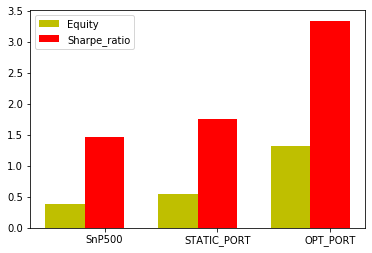

In [152]:
names = ['SnP500','STATIC_PORT','OPT_PORT']
ind = np.arange(3)
width = 0.35       
p0 = plt.bar(ind, [x for x in equity], width, color='y')
p1 = plt.bar(ind+width, [x for x in sharpe], width, color='r')


plt.xticks(ind + width, names)
plt.legend((p0[0], p1[0]), ('Equity', 'Sharpe_ratio'), loc=2)

plt.show()

# Вывод

### Портфельная теория, которая была зафичена на данных 2010-2017 года показывает хорошие результаты на промежутке 2017-2020, опережая по вышеуказанным показателям индекс и статический портфель из бумаг.
### Эту модель можно улучшать в нескольких направлениях:
1. Переход к более узкой обучающей выборке: секторные и полисекторные регрессии, исключение из выборки компаний с низкой капитализацией и тп.
2. Провести на хорошем компьютере полный прогон статистического критерия Bai and Ng на всевозможных количествах факторов.
3. Изучение оптимальной частоты ребалансировки портфеля. Требуется более серьезная модель, которая будет учитывать транзакционные издержки и спреды bid/ask.